# Single physics tutorial
In this tutorial we visit how to run single physics simulations in PorePy. 
The problem in question is that of single phase flow, and we will cover both incompressible and slightly compressible flow.


We start off by importing the necessary packages:

In [67]:
import porepy as pp
import numpy as np

There is already a model for the single phase flow problem within PorePy, which makes running simulations possible with only a few lines of code.
The model can be run by using the SinglePhaseFlow class within the fluid_mass_balance.py file. 
It contains everything one needs to run a simulation.

By default there are the needed geometry related methods and information for a simulation, but as this geometry is only a unitary domain without any fractures we might want to change it.
In order to modify if we will need to overwrite certain methods that are found in ``pp.ModelGeometry``, which is where the geometry related methods and information are found.

So, for obtaining a more interesting model geometry we define a mixin which takes care of setting a fracture into our domain:

In [68]:

class Geometry:
    def set_fracture_network(self) -> None:
        points = np.array([[0.2, 0.8], [0.2, 0.8]])

        domain = pp.Domain(bounding_box={"xmin": 0, "xmax": 1, "ymin": 0, "ymax": 1})

        frac = pp.LineFracture(points)

        self.fracture_network = pp.FractureNetwork2d(fractures=[frac], domain=domain)

    def mesh_arguments(self) -> dict:
        mesh_args: dict[str, float] = {"mesh_size_frac": 0.075}
        return mesh_args


This mixin, named ``Geometry``, sets a diagonal fracture into our domain.
To make a new model with the modified geometry, we simply combine ``Geometry`` with the standard model using multiple inheritance:


In [69]:
class SinglePhaseFlowTutorial(
    Geometry,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

Running the simulation and plotting the results are done by calls to ``pp.run_time_dependent_model()`` and ``pp.plot_grid()``, respectively:

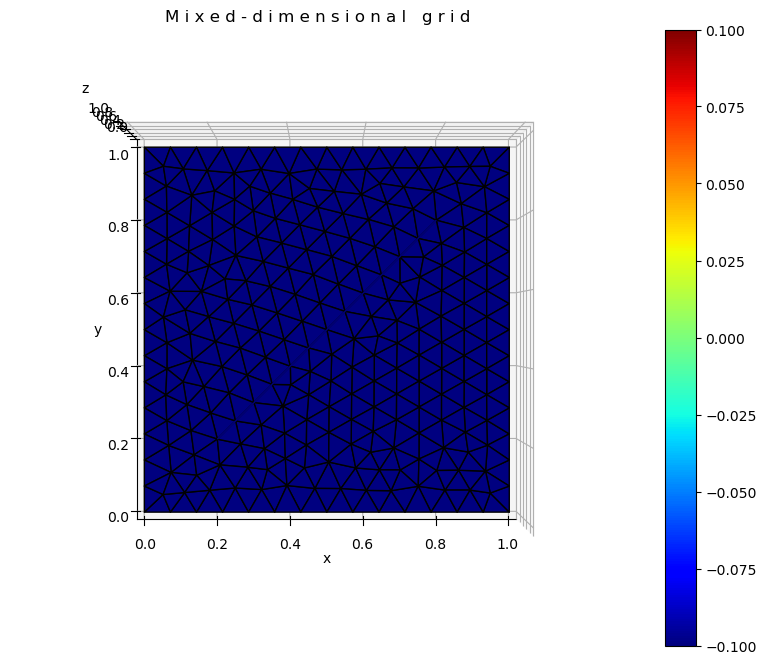

In [70]:
params = {}
single_phase = SinglePhaseFlowTutorial(params)  
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure", figsize=(10, 8))

As we have not changed anything that would introduce a flux to the system, the solution is only constant.
Therefore we will define some non-zero boundary conditions such that the solution is more exciting. 

This is done similar to how we modified the geometry, so we now define a mixin for the boundary conditions.
Methods for the boundary conditions are already present in the default model class, so obtaining other boundary conditions is done by overwriting the methods ``bc_type`` and ``bc_values_darcy``.

In [71]:
class IncompressibleFlowBC:
    def bc_type(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        """Assign dirichlet to the west boundaries. The rest are Neumann by default."""
        _, _, west, _, _, _, _ = self.domain_boundary_sides(sd)
        bc = pp.BoundaryConditionVectorial(sd, west, "dir")
        bc.internal_to_dirichlet(sd)
        return bc

    def bc_values_darcy(self, subdomains: list[pp.Grid]):
        """Zero bc value on top and bottom, 10 on west side, 5 on east side."""
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, east, west, _, _, _, _ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[west] = self.fluid.convert_units(10, "Pa")
            val_loc[east] = self.fluid.convert_units(5, "Pa")
            values.append(val_loc)
        return pp.wrap_as_ad_array(np.hstack(values), name="bc_values_darcy")

To combine the standard model with the new geometry _and_ the boundary conditions, we simply create a new class which inherits from all of them:

In [72]:
class SinglePhaseFlowTutorial(
    Geometry,
    IncompressibleFlowBC,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

And while we are at it, we might as well change some of the parameters found in the model.
The different constants are divided into fluid and solid constants, and are specified by creating an instance of the respective fluid and solid constant classes.

In [73]:
fluid_constants = pp.FluidConstants({"viscosity": 0.1, "density": 0.2})
solid_constants = pp.SolidConstants({"permeability": 0.5, "porosity": 0.25})
material_constants = {"fluid": fluid_constants, "solid": solid_constants}
params = {"material_constants": material_constants}


Running the simulation is done similar to before, only that ``params`` is not an empty dictionary:

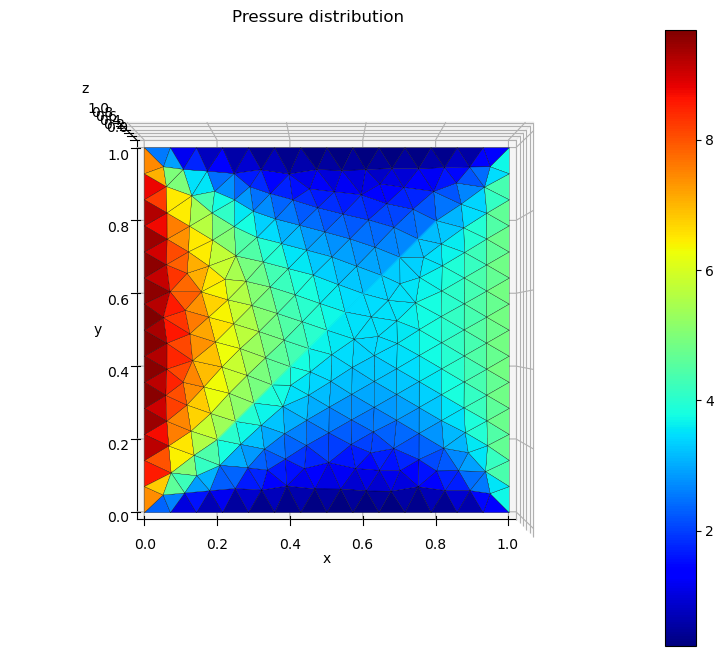

In [74]:
single_phase = SinglePhaseFlowTutorial(params)
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure", figsize=(10, 8), linewidth=0.2, title="Pressure distribution")

Another way to modify the model is to include a fracture source.
Below we demonstrate how a unitary fracture source can be included.

In [75]:
class ModifiedSource:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Contribution of mass fluid sources to the mass balance equation.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise Ad operator containing the fluid source contributions.

        """
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []

        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells))
        external_sources = pp.wrap_as_ad_array(np.hstack(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source
    


For the sake of seeing the effects of the unitary fracture source, we do not include the non-zero boundary conditions

In [76]:
class SinglePhaseFlowTutorial(
    Geometry,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...


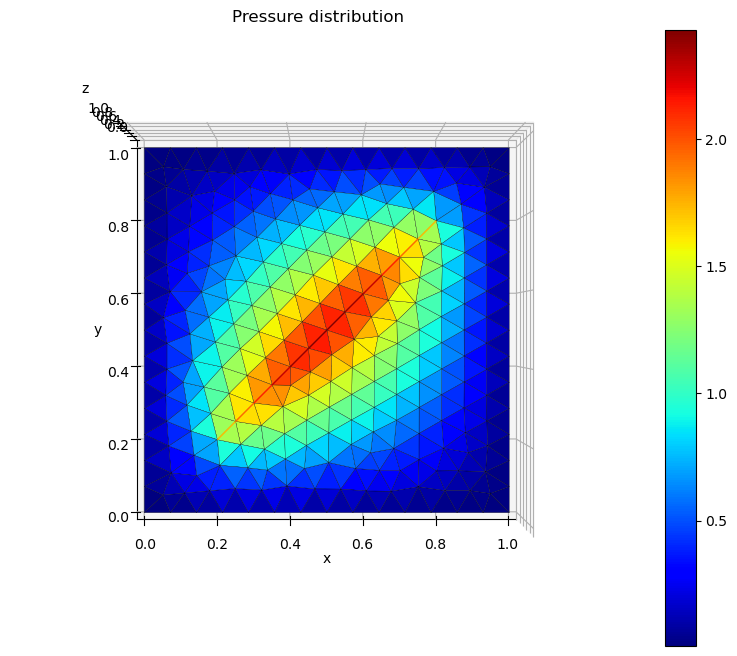

In [77]:
single_phase = SinglePhaseFlowTutorial(params)
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure", figsize=(10, 8), linewidth=0.2, title="Pressure distribution")